In [2]:
from typing import Tuple

import matplotlib.pyplot as plt
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from src.files_io import load_raw_mailout_datasets, download_and_extract_raw_datasets
from src.preprocessing import preprocess_data

# Load & Preprocess Data
We only use the mailout dataset with provided responses (= target variable) to train and evaluate the customer prediction model.

In [3]:
download_and_extract_raw_datasets()

Raw Datasets already exists.


In [4]:
train_raw, _ = load_raw_mailout_datasets()

Mailout datasets loaded.


Our preprocessing would remove the response variable. This is why we need to join the response values after the applied preprocessing.

In [5]:
train_response = train_raw["response"]

In [6]:
train_preprocessed, _ = preprocess_data(train_raw, _, ("train", "unused test"))

Metadata loaded.
Metadata rectified.
Feature config loaded.

Start cleaning train dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7962 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_kind4, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 136 features.
Extracted decade and cultural orientation as separate features.
Extracted wealth and life phase as separate features.
Removed 51 redundant features.
Removed 24 uncertain features.

Start cleaning unused test dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7841 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_kind4

In [7]:
train_preprocessed = train_preprocessed.join(train_response, how="left")

assert train_preprocessed["response"].isnull().sum() == 0

# Class Imbalance
An important aspect is the extreme class imbalance in out mailout dataset, that needs to be considered for the model development. Only about 1% of the data are customers.

In [8]:
train_preprocessed["response"].value_counts(normalize=True)

response
0    0.987571
1    0.012429
Name: proportion, dtype: float64

# Split Training Data
To avoid data leakage and ensure an unbiased evaluation, we use a validation set for early stopping and hyperparameter tuning and a separate test set (data that the model has never seen before) for the final evaluation:
  - training set: for model training
  - validation set: for early stopping and hyperparameter tuning
  - test set: for final evaluation

Due to the high class imbalance, we use a stratified sampling approach to make sure, that the rare customers in our data are equally distributed.

In [9]:
train, validation_test = train_test_split(train_preprocessed, test_size=0.3, random_state=10, stratify=train_preprocessed["response"])

validation, test = train_test_split(validation_test, test_size=0.5, random_state=10, stratify=validation_test["response"])

del validation_test

# XGBoost Classification Model
Our goal is to predict weather or not an individual will be a potential customer. This means that we have a binary classification task to solve.

One possible algorithm approach are gradient boosting decision trees. They are highly effective and very successful in solving various machine learning problems.

A good choice could be XGBoost, that can appropriately handle class imbalance with the `scale_pos_weigth` parameter. Furthermore, XGBoost offers an early stopping method to stop the training when our target metric do not increase anymore.

We use ROC AUC as our evaluation metric, because it seems to be the best fit for our business problem:
- offers a comprehensive evaluation of model performance by assessing the trade-off between recall and false positive rate across different thresholds
- maximizing recall (true positive rate) is essential to identify as many potential customers as possible
- control false positive rate is also crucial to avoid spamming uninterested users and protect brand reputation

In [11]:
def split_features_and_response(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    y = df["response"]
    X = df.drop(columns=["response"])
    return X, y


X_train, y_train = split_features_and_response(train)
dtrain = xgb.DMatrix(data=X_train, label=y_train)

X_validation, y_validation = split_features_and_response(validation)
dvalidation = xgb.DMatrix(data=X_validation, label=y_validation)

A typical recommended value for the `scale_pos_weight` parameter is `sum(negative instances) / sum(positive instances)`.

In [12]:
sum_negatives = len(y_train) - sum(y_train)
sum_positives = sum(y_train)
scale_pos_weight = sum_negatives / sum_positives

## Hyperparameter Tuning
One efficient way to tune the hyperparameters of our XGBoost model is by using the Optuna framework. Optuna mainly uses a method called Tree-structured Parzen Estimator (TPE) as its optimization strategy, which is a type of Bayesian optimization:
- instead of trying random hyperparameters, Optuna models the probability distribution of good vs. bad hyperparameters
- it learns over time which areas of the search space are promising and then focusing more on these regions
- we just need to define:
  - the ranges for each XGBoost hyperparameter to be considered
  - the metric and its direction that we want to optimize for (maximize ROC AUC)
  - the number of trials

In [14]:
def tuning_objective(trial):
    hyperparameter_trial = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "scale_pos_weight": scale_pos_weight,
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-4, 10, log=True),
        "lambda": trial.suggest_float("lambda", 1e-4, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 10, log=True),
        "random_state": 42
    }

    model = xgb.train(
        hyperparameter_trial,
        dtrain,
        num_boost_round=1000,
        evals=[(dvalidation, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred = model.predict(dvalidation)
    score = roc_auc_score(y_validation, y_pred)

    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(tuning_objective, n_trials=100, show_progress_bar=True)

print(study.best_params)

Best trial: 17. Best value: 0.77075: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]

{'eta': 0.052779859647620476, 'max_depth': 5, 'min_child_weight': 0.12044467652419318, 'subsample': 0.5986519552222838, 'colsample_bytree': 0.6607876092127668, 'gamma': 1.6601873086551937, 'lambda': 0.0009779967793185874, 'alpha': 0.0033489593289916454}


After determining the hyperparameters we train the final model with that parameter setting.

In [15]:
static_hyperparameters = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"], # last item ("auc") will be used for early stopping
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
}

best_hyperparameters = static_hyperparameters | study.best_params

evals_result = {}

model = xgb.train(
    params=best_hyperparameters,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dvalidation, "validation")],
    evals_result=evals_result,
    early_stopping_rounds=15,
    num_boost_round=1000,
)

[0]	train-logloss:0.67121	train-auc:0.79974	validation-logloss:0.67225	validation-auc:0.68839
[1]	train-logloss:0.64769	train-auc:0.82852	validation-logloss:0.64991	validation-auc:0.72825
[2]	train-logloss:0.62751	train-auc:0.84331	validation-logloss:0.63058	validation-auc:0.73217
[3]	train-logloss:0.61430	train-auc:0.86228	validation-logloss:0.61787	validation-auc:0.74252
[4]	train-logloss:0.60194	train-auc:0.86991	validation-logloss:0.60617	validation-auc:0.74185
[5]	train-logloss:0.59542	train-auc:0.87235	validation-logloss:0.60007	validation-auc:0.73519
[6]	train-logloss:0.58548	train-auc:0.88534	validation-logloss:0.59095	validation-auc:0.73213
[7]	train-logloss:0.57870	train-auc:0.89143	validation-logloss:0.58480	validation-auc:0.73006
[8]	train-logloss:0.57090	train-auc:0.89902	validation-logloss:0.57731	validation-auc:0.73168
[9]	train-logloss:0.55571	train-auc:0.90084	validation-logloss:0.56238	validation-auc:0.73689
[10]	train-logloss:0.54823	train-auc:0.90318	validation-logl

## Training Curves
Although we are using early stopping, it is crucial to assess overfitting and underfitting, because it helps identify whether a model is learning the underlying patterns in the data or simply memorizing the training samples.

Our model seems to be well-tuned, with no signs of significant overfitting or underfitting based on the log loss curves.

In [16]:
def plot_metric(evals_result, metric_name):
    epochs = len(evals_result["train"][metric_name])
    x_axis = range(0, epochs)

    plt.figure(figsize=(15,4))
    plt.plot(x_axis, evals_result["train"][metric_name], label="Train", color="indianred")
    plt.plot(x_axis, evals_result["validation"][metric_name], label="Validation", color="royalblue")
    plt.xlabel("Boosting Round")
    plt.ylabel(metric_name.upper())
    plt.title(f"Training and Validation {metric_name.upper()}")
    plt.legend()
    plt.grid()
    plt.show()

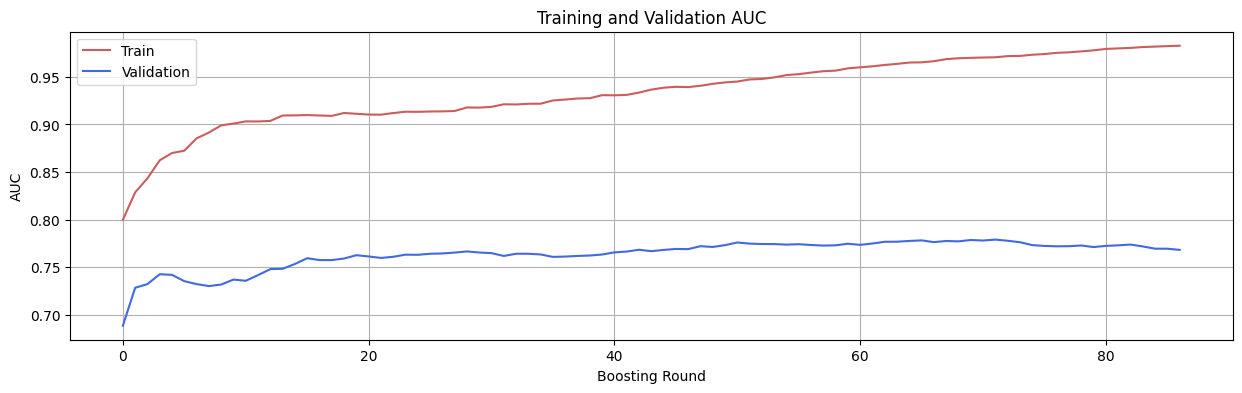

In [17]:
plot_metric(evals_result, "auc")

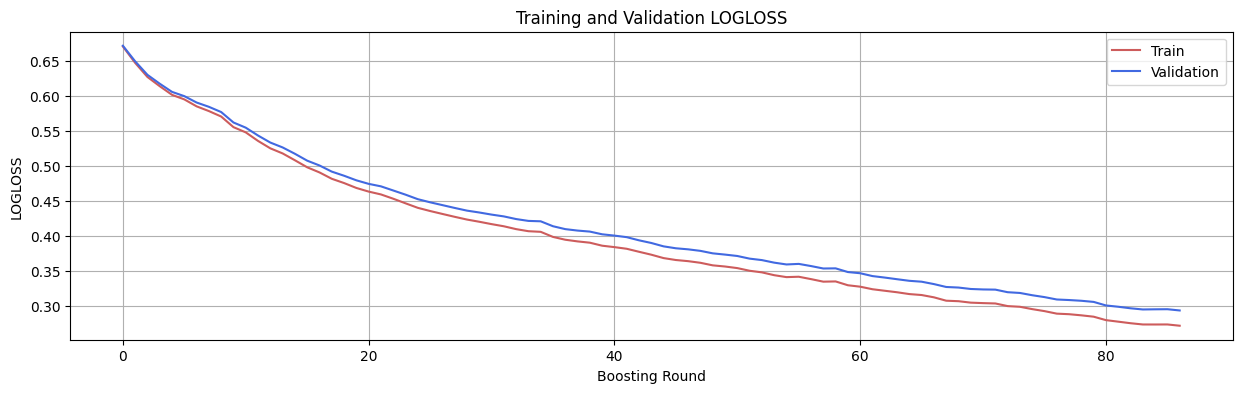

In [18]:
plot_metric(evals_result, "logloss")

## Evaluation
As mentioned before, we use our separated test dataset to evaluate the model performance.

The ROC curve provides several insights of our model's performance:
- the curve plots the true positive rate (TPR) against the false positive rate (FPR)
  - a higher TPR indicates that the model is effectively identifying the customers (positive cases)
  - a lower FPR indicates that it is not incorrectly labeling too many negative cases as positive (sending mails to uninterested people)
- the "area under the curve" (AUC) is 0.79, which suggests that the model has a good ability to distinguish between customers and non-customers (an AUC of 0.5 would indicate random guessing)
- the ROC curve rises steeply in the lower left corner, which is favorable, as it indicates that the model achieves a high true positive rate (identifies many potential customers) with a low false positive rate (sending unnecessary mails) at lower thresholds
- the relatively gradual slope in the mid-range suggests that the "spam rate" significantly increases while only a limited number of additional customers are being identified

A possibly good trade-off would be at around 0.88 TPR and 0.35 FPR, which means that 88% of the potential customers were identified while avoiding 65% of unnecessary "spam" mails.

In [19]:
X_test, y_test = split_features_and_response(test)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [20]:
y_pred = model.predict(dtest, output_margin=False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

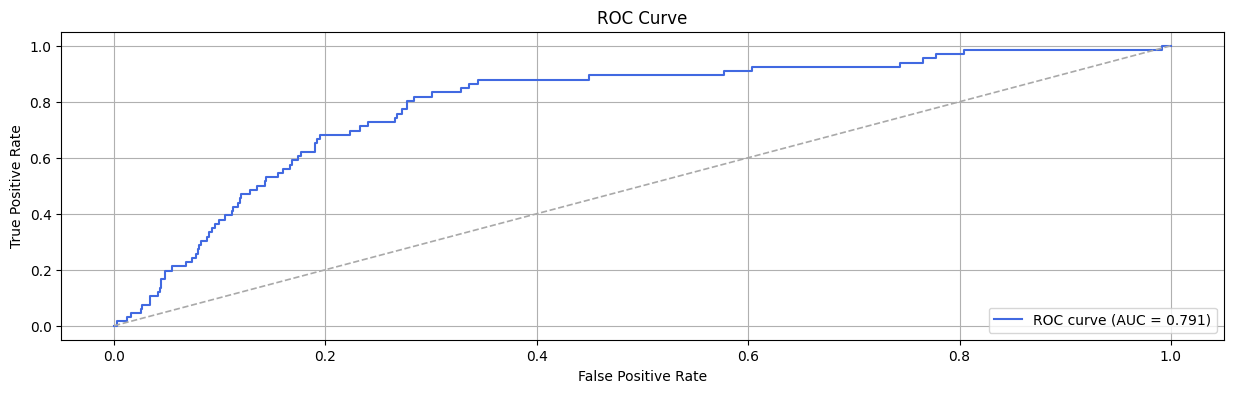

In [39]:
plt.figure(figsize=(15, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="royalblue")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, color="darkgray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The threshold on the predicted probabilities for the suggestest trade-off above would be around `0.16`. This means that any predicted probability value of our model over the threshold value will be classified as a potential customer.

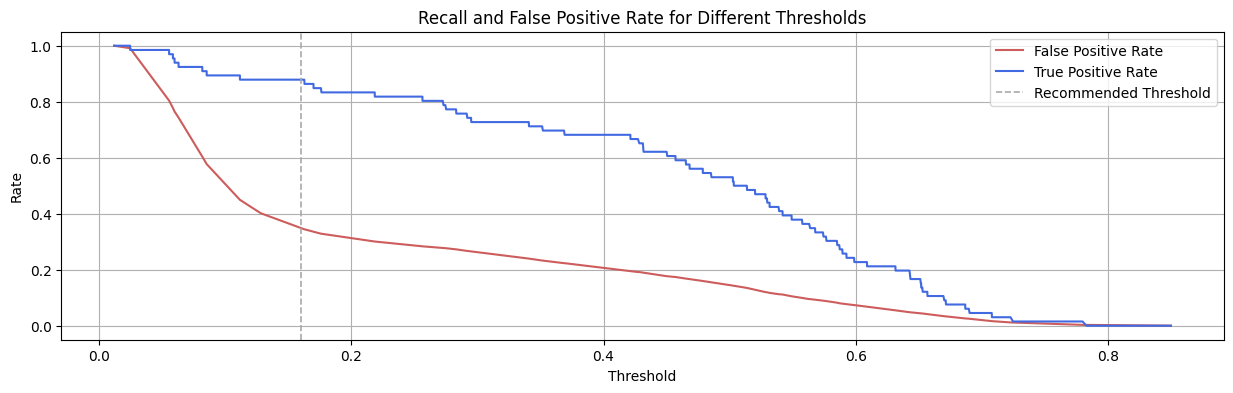

In [38]:
plt.figure(figsize=(15,4))
plt.plot(thresholds, fpr, label="False Positive Rate", color="indianred")
plt.plot(thresholds, tpr, label="True Positive Rate", color="royalblue")
plt.axvline(x=0.16, color="darkgray", linestyle="--", linewidth=1.2, label="Recommended Threshold")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Recall and False Positive Rate for Different Thresholds")
plt.legend()
plt.grid()
plt.show()

# Conclusion
As already said in the evaluation part, our model has a good ability to distinguish between customers and non-customers.

Nevertheless, there are possibly some improvements that could be further tweak our model and maybe worth to be tested:
- upsampling the customer class or downsampling the majority class (non-customers) instead of only using the `scale_pos_weight` parameter
- test other model types: CatBoost, LightGBM, Random Forest, SVMs, ...
- further refine the preprocessed data
- try other hyperparameter strategies and use more trials